In [99]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras.layers import Dense
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm_notebook as tqdm
tf.keras.backend.set_floatx('float64')
from collections import deque
from datetime import datetime
import random


def Prob(alpha, beta, n):
    p0 = np.exp(-(alpha-beta)**2)
    if n == 0:
        return p0
    else:
        return 1-p0

def qval(beta, n, guess):
    #dolinar guessing rule (= max-likelihood for L=1, careful sign of \beta)
    alpha = 0.4
    pn = np.sum([Prob(g*alpha, beta, n) for g in [-1,1]])
    return Prob(guess*alpha, beta, n)/pn

def ps_maxlik(beta):
    #dolinar guessing rule (= max-likelihood for L=1, careful sign of \beta)
    alpha = 0.4
    p=0
    for n1 in [0,1]:
       p+=Prob(np.sign(beta)*(-1)**(n1)*alpha, beta, n1)
    return p/2


class DataSet():
    def __init__(self, size=10**3, nbetas=10,rpbgo=-1, creation_mode = "TrueSampling"):
        #rpbgo = rewards per beta-guess-outcome
        self.size = size
        self.amplitude = 0.4
        step = np.round(3/nbetas,3)
        self.betas = np.arange(-1.5, 1.5+step,step)
        self.rpbgo = rpbgo

        if creation_mode == "TrueSampling":
            self.data_unsplitted, self.test_l0, self.test_l1 =self.create_dataset_true_sampling()
        elif creation_mode == "Uniform":
            self.data_unsplitted=self.create_dataset_uniform_sampling()

    def create_dataset_true_sampling(self):
        d=[]
        dt_l2 = []
        dt_l1 = []
        
        for k in self.betas:
            dt_l1.append([k, ps_maxlik(k)])
            for n in [0.,1.]:
                for g in [-1.,1.]:
                    dt_l2.append([k, n, g, qval(k,n,g)])
                    
        for repetitions in range(self.size):
            ph = np.random.choice([-1.,1.],1)[0]
            beta = np.random.choice(self.betas,1)[0]
            proboutcome = Prob(ph*self.amplitude,beta,0)
            outcome = np.random.choice([0.,1.],1,p=[proboutcome, 1-proboutcome])[0]
            guess = np.random.choice([-1.,1.],1)[0]
            mean_bernoulli = qval(beta, outcome, guess)
            if guess == ph:
                reward = 1
            else:
                reward = 0
            #reward = np.random.choice([1.,0.,],1,p=[mean_bernoulli, 1.-mean_bernoulli])[0]
            d.append([beta,outcome,guess,reward])
        return np.array(d), np.array(dt_l1), np.array(dt_l2)
    
    def create_dataset_uniform_sampling(self):
        if self.rpbgo!=-1:
            self.size = 4*nbetas*rpbgo
        d=[]
        
        #for episode in range(size):
        for b in self.betas:
            for outcome in [0.,1,]:
                for guess in [-1.,1.]:
                    for k in range(self.rpbgo):
                        mean_bernoulli = qval(b, outcome, guess)
                        reward = np.random.choice([1.,0,],1,p=[mean_bernoulli, 1.-mean_bernoulli])[0]
                        d.append([b, outcome, guess, reward])

    
    def sample_minibatch(self, bs):
        #samples a minibatch of full history of transitions: a0 -> h0 -> a1 -> h1 -> r2.
        #returns a random sample of {a0}, {h1-a1}, {r2} ordered!
        d = self.data_unsplitted[np.random.choice(np.arange(self.size),int(bs),replace=False)]
        a0s = d[:,0]
        h0s_a1s = d[:,[0,1,2]]
        r2s = d[:,3]
        return a0s, h0s_a1s, r2s
    
    def pre_process(self, data):
        data_prep = []
        for ind, d in enumerate(data):
            a0s = d[:,0]
            h0s_a1s = d[:,[0,1,2]]
            r2s = d[:,3]
            data_prep.append([a0s, h0s_a1s, r2s])
        return data_prep
    
    
    def give_epoch(self, bs):
        #gives a list of batches that form an epoch
        epoch=[]
        data = self.data_unsplitted.copy()
        np.random.shuffle(data)
        data = self.BatchSizeSplit(data, bs)[0]
        data = self.pre_process(data)
        return data
        #for k in range(int(self.siz|e/bs)):
         #   epoch.append(self.sample_minibatch(bs))
        #return epoch
    
    def BatchSizeSplit(self, dataset,batch_size):
        
        splits = int(len(dataset)/batch_size)
        if len(dataset)%batch_size !=0:
            #print("Not divisible!: breaking into len(dataset)%batch_size")
            splits = int(len(dataset)/batch_size)
            sobra = int(len(dataset)%batch_size)
            splited = np.split(dataset[sobra:], splits + len(dataset[sobra:])%splits)
            return splited, len(splited[0])
        else:
            splited = np.split(dataset, splits + len(dataset)%splits)
            return splited, len(splited[0])


#### Plotting what we'll use (and what we wanna learn)

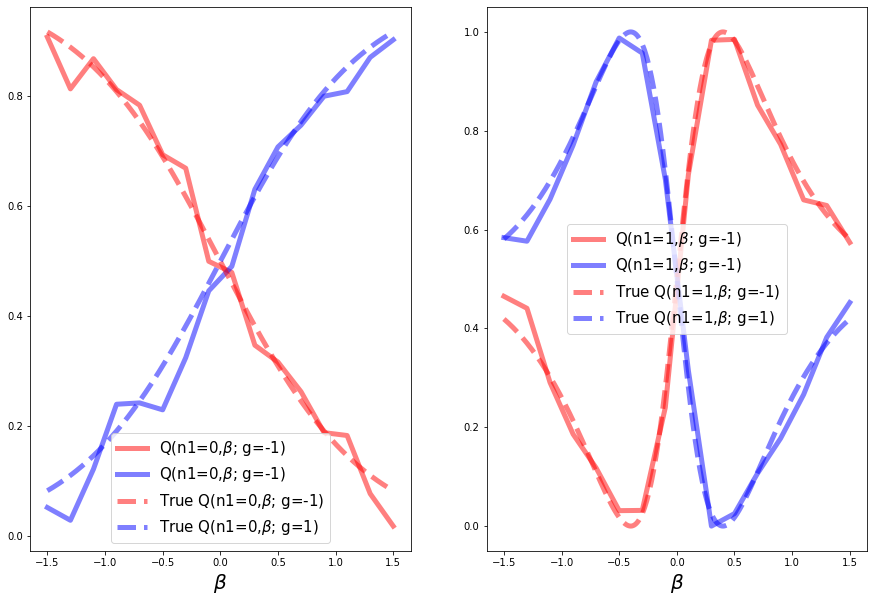

In [28]:
dataset = DataSet(size=10**4, nbetas=15)

histo = {}
number = {}
for k in dataset.betas:
    for g in [-1.,1.]:
        for outcome in [0.,1.]:
            
            histo[str(k)+"n"+str(outcome)+"g"+str(g)] = 0
            number[str(k)+"n"+str(outcome)+"g"+str(g)] = 1

for dato in dataset.data_unsplitted:
    histo[str(dato[0])+"n"+str(dato[1])+"g"+str(dato[2])] += dato[3]
    number[str(dato[0])+"n"+str(dato[1])+"g"+str(dato[2])] += 1
    
for k in dataset.betas:
    for g in [-1.,1.]:
        for outcome in [0.,1.]:
            histo[str(k)+"n"+str(outcome)+"g"+str(g)] /=number[str(k)+"n"+str(outcome)+"g"+str(g)] 


plt.figure(figsize=(15,10))
ax1 =  plt.subplot2grid((1,2),(0,0))
ax2 =  plt.subplot2grid((1,2),(0,1))

betas_train = dataset.betas
ax1.plot(dataset.betas,[histo[str(b)+"n0.0g-1.0"] for b in betas_train],alpha=0.5,c="red", linewidth=5, label="Q(n1=0,"+r'$\beta$'+"; g=-1)")
ax1.plot(dataset.betas,[histo[str(b)+"n0.0g1.0"] for b in betas_train],alpha=0.5,c="blue", linewidth=5, label="Q(n1=0,"+r'$\beta$'+"; g=-1)")

ax2.plot(dataset.betas,[histo[str(b)+"n1.0g-1.0"] for b in betas_train],alpha=0.5,c="red", linewidth=5, label="Q(n1=1,"+r'$\beta$'+"; g=-1)")
ax2.plot(dataset.betas,[histo[str(b)+"n1.0g1.0"] for b in betas_train],alpha=0.5,c="blue", linewidth=5, label="Q(n1=1,"+r'$\beta$'+"; g=-1)")

betas = np.arange(-1.5,1.5,.01)
ax1.plot(betas,[qval(b, 0, -1) for b in betas],'--',alpha=0.5,c="red", linewidth=5, label="True Q(n1=0,"+r'$\beta$'+"; g=-1)")
ax1.plot(betas,[qval(b, 0, 1) for b in betas],'--',alpha=0.5,c="blue",  linewidth=5,label="True Q(n1=0,"+r'$\beta$'+"; g=1)")

ax2.plot(betas,[qval(b, 1, -1) for b in betas],'--',alpha=0.5,c="red",  linewidth=5,label="True Q(n1=1,"+r'$\beta$'+"; g=-1)")
ax2.plot(betas,[qval(b, 1, 1) for b in betas],'--',alpha=0.5,c="blue",  linewidth=5,label="True Q(n1=1,"+r'$\beta$'+"; g=1)")


for ax in [ax1, ax2]:
    ax.set_xlabel(r'$\beta$', size=20)
    ax.legend(prop={"size":15})


### Now we'll define a function to plot the predictions, but this is just to visualize; next we'll define yet another two out-of-sample loss functions and check everything in that terms

In [127]:
def plot_predictions_profiles(histo_preds, losses, betas, title=None, save=True, directory="/"):

    plt.figure(figsize=(25,20))
    ax1 =  plt.subplot2grid((2,4),(0,0))
    ax2 =  plt.subplot2grid((2,4),(0,1))
    ax3 = plt.subplot2grid((2,4),(1,0), colspan=2)
    ax4 = plt.subplot2grid((2,4),(0,2))
    ax5 = plt.subplot2grid((2,4),(1,2))
    ax6 = plt.subplot2grid((2,4),(0,3))
    ax7 = plt.subplot2grid((2,4),(1,3))


    betas_train = betas
    for predictions in histo_preds["net_1"].values():
        ax1.plot(betas_train,predictions["values"]["0"],alpha=0.25, linewidth=5)#, label="epoch: "+str(predictions["epoch_number"])) #, label=r'$\hat{Q}$'+"(n1=0,"+r'$\beta$'+"; g=-1)")
        ax1.plot(betas_train,predictions["values"]["1"],alpha=0.25, linewidth=5)#, label="epoch: "+str(predictions["epoch_number"]))#,label=r'$\hat{Q}$'+"(n1=0,"+r'$\beta$'+"; g=1)")

        ax2.plot(betas_train,predictions["values"]["2"] ,alpha=0.25,  linewidth=5)#, label="epoch: "+str(predictions["epoch_number"]))#label=r'$\hat{Q}$'+"(n1=1,"+r'$\beta$'+"; g=-1)")
        ax2.plot(betas_train,predictions["values"]["3"] ,alpha=0.25,  linewidth=5)#, label="epoch: "+str(predictions["epoch_number"]))#,label=r'$\hat{Q}$'+"(n1=1,"+r'$\beta$'+"; g=1)")
    
    #Now we take the last and plot it in bold!
    ax1.plot(betas_train,predictions["values"]["0"],alpha=0.85, c="black",linewidth=8)#), label="epoch: "+str(predictions["epoch_number"])) #, label=r'$\hat{Q}$'+"(n1=0,"+r'$\beta$'+"; g=-1)")
    ax1.plot(betas_train,predictions["values"]["1"],alpha=0.85, c="purple", linewidth=8)#, label="epoch: "+str(predictions["epoch_number"]))#,label=r'$\hat{Q}$'+"(n1=0,"+r'$\beta$'+"; g=1)")
    ax1.scatter(betas_train,predictions["values"]["0"],alpha=0.85, c="black",s=150)
    ax1.scatter(betas_train,predictions["values"]["1"],alpha=0.85, c="purple",s=150)
    
    ax2.plot(betas_train,predictions["values"]["2"] ,alpha=0.85, c="black", linewidth=8)#, label="epoch: "+str(predictions["epoch_number"]))#label=r'$\hat{Q}$'+"(n1=1,"+r'$\beta$'+"; g=-1)")
    ax2.plot(betas_train,predictions["values"]["3"] ,alpha=0.85,  c="purple",linewidth=8)#, label="epoch: "+str(predictions["epoch_number"]))#,label=r'$\hat{Q}$'+"(n1=1,"+r'$\beta$'+"; g=1)")
    ax2.scatter(betas_train,predictions["values"]["2"],alpha=0.85, c="black",s=150)
    ax2.scatter(betas_train,predictions["values"]["3"],alpha=0.85, c="purple",s=150)

    
    ### we do the same for ax3:
    
    for predictions in histo_preds["net_0"].values():
        ax3.plot(betas_train,predictions["values"],alpha=0.15, linewidth=5)#, label="epoch: "+str(predictions["epoch_number"])) #, label=r'$\hat{Q}$'+"(n1=0,"+r'$\beta$'+"; g=-1)")

    #The last one black and bigger!
    ax3.plot(betas_train,predictions["values"],alpha=0.85,c="black", linewidth=5)#, label="epoch: "+str(predictions["epoch_number"])) #, label=r'$\hat{Q}$'+"(n1=0,"+r'$\beta$'+"; g=-1)")


    
    ax1.plot(betas,[qval(b, 0, -1) for b in betas],'--',alpha=0.85,c="red", linewidth=8, label="Q(n1=0,"+r'$\beta$'+"; g=-1)")
    ax1.plot(betas,[qval(b, 0, 1) for b in betas],'--',alpha=0.85,c="blue",  linewidth=8,label="Q(n1=0,"+r'$\beta$'+"; g=1)")

    ax2.plot(betas,[qval(b, 1, -1) for b in betas],'--',alpha=0.85,c="red",  linewidth=8,label="Q(n1=1,"+r'$\beta$'+"; g=-1)")
    ax2.plot(betas,[qval(b, 1, 1) for b in betas],'--',alpha=0.85,c="blue",  linewidth=8,label="Q(n1=1,"+r'$\beta$'+"; g=1)")

    ax3.plot(betas,[ps_maxlik(b) for b in betas],'--',alpha=0.85,c="red", linewidth=8)
    ax3.set_xlabel(r'$\beta$', size=20)
    ax3.set_ylabel(r'$P_s\; ( \beta )$', size=20)
    
    
    
    for ax in [ax1, ax2,ax3]:
        ax.set_xlabel(r'$\beta$', size=20)
        ax.legend(prop={"size":15})
    if title != None:
        plt.suptitle(title, size=50)
        
     #### not plot the losses"####   
    c=0
    lab = ["train","test"]
    for ax, loss in zip([ax4,ax5],losses[0]):
        ax.plot(np.arange(1,len(loss)+1),loss,'--',alpha=0.85,c="red", linewidth=5, label="Preds Q(\beta) - "+lab[c])#, label="Q(n1=0,"+r'$\beta$'+"; g=-1)")
        ax.scatter(np.arange(1,len(loss)+1),loss,s=150,alpha=0.85,c="red", linewidth=5,label="Preds Q(\beta) - "+lab[c])#, label="Q(n1=0,"+r'$\beta$'+"; g=-1)")
        c+=1
        ax.set_xlabel("epoch", size=20)
        ax.set_ylabel("Loss Q(\beta_1)",size=20)
        
    c=0
    for ax, loss in zip([ax6,ax7],losses[1]):
        ax.plot(np.arange(1,len(loss)+1),loss,'--',alpha=0.85,c="red", linewidth=5, label="Preds Q(n, \beta, guess) - "+lab[c])#, label="Q(n1=0,"+r'$\beta$'+"; g=-1)")
        ax.scatter(np.arange(1,len(loss)+1),loss,s=150,alpha=0.85,c="red", linewidth=5, label="Preds Q(n, \beta, guess) - "+lab[c])#, label="Q(n1=0,"+r'$\beta$'+"; g=-1)")

        ax.set_xlabel("epoch", size=20)
        ax.set_ylabel("Loss Q(\beta_1, n, guess)",size=20)
    if save==True:
        plt.savefig(directory+"profiles.png")
    plt.close()
    return

### This is a function to calculte $\text{max}_a_{t+1} Q(s_{t+1}, a_{t+1})$

In [67]:

class Net(tf.keras.Model):
    #input_dim: 1 if layer=0, 3 if layer= 2, for the Kennedy receiver ##
    def __init__(self, input_dim, valreg=0.01, seed_val=0.1):
        super(Net,self).__init__()

        self.l1 = Dense(50, input_shape=(input_dim,),kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
        bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
        kernel_regularizer=tf.keras.regularizers.l1(valreg),
    activity_regularizer=tf.keras.regularizers.l2(valreg))

        self.l2 = Dense(50, kernel_regularizer=tf.keras.regularizers.l1(valreg),
    activity_regularizer=tf.keras.regularizers.l2(valreg),
    kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
    bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))
        self.l3 = Dense(50, kernel_regularizer=tf.keras.regularizers.l1(valreg),
    activity_regularizer=tf.keras.regularizers.l2(valreg),
    kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
    bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))

        self.l4 = Dense(50, kernel_regularizer=tf.keras.regularizers.l1(valreg),
    activity_regularizer=tf.keras.regularizers.l2(valreg),
    kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
    bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))

        self.l5 = Dense(1, kernel_regularizer=tf.keras.regularizers.l1(valreg),
    activity_regularizer=tf.keras.regularizers.l2(valreg),
    kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
    bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))

        
    def update_target_parameters(self,primary_net, tau=0.01):
        #### only 
        prim_weights = primary_net.get_weights()
        targ_weights = self.get_weights()
        weights = []
        for i in tf.range(len(prim_weights)):
            weights.append(tau * prim_weights[i] + (1 - tau) * targ_weights[i])
        self.set_weights(weights)
        return

    def call(self, input):
        feat = tf.nn.relu(self.l1(input))
#        feat = tf.nn.dropout(feat, rate=0.01)
 #       feat = tf.nn.relu(self.l2(feat))
  #      feat = tf.nn.dropout(feat, rate=0.01)
   #     feat = tf.nn.relu(self.l3(feat))
        feat = tf.nn.relu(self.l4(feat))
        feat = tf.nn.sigmoid(self.l5(feat))
        return feat

    def calculate_greedy_from_batch(self, batch):
        """ this function is only to intended for Q(n, beta, guess)"""
        a = batch[1].copy()
        preds1 = self(a)
        a[:,2] = -a[:,2]
        preds2 = self(a)
        both = tf.concat([preds1,preds2],1)
        maxs = np.squeeze(tf.math.reduce_max(both,axis=1))
        maxs = np.expand_dims(maxs, axis=1)
        return maxs

    def __str__(self):
        return self.name


In [147]:
def supervised_training(batch_size=32., total_epochs=30, buffer_size=10**4, tau=0.0005, lr=0.001):

    net_0 = Net(input_dim=1)
    net_1 = Net(input_dim=3)
    net_1_target = Net(input_dim=3)

    net_0(np.array([[0.],[1.]])) #initialize the network 0, arbitrary inputs.
    net_1(np.array([[0.,1.,1.]]))
    net_1_target(np.array([[0.,1.,1.]]))

    optimizer_0 = tf.keras.optimizers.Adam(lr=lr)
    optimizer_1 = tf.keras.optimizers.Adam(lr=lr)

    dataset = DataSet(size=10**4, nbetas=15)
    
    
    
    #current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
    current_time = "BATCH_SIZE_{}__TAU_{}__LR_{}".format(batch_size, tau, lr)
    train_log_dir_0 = 'logs/gradient_tape/' + current_time + '/train_l0'
    test_log_dir_0 = 'logs/gradient_tape/' + current_time + '/test_l0'
    train_log_dir_1 = 'logs/gradient_tape/' + current_time + '/train_l1'
    test_log_dir_1 = 'logs/gradient_tape/' + current_time + '/test_l1'
    train_summary_writer_0 = tf.summary.create_file_writer(train_log_dir_0)
    train_summary_writer_1 = tf.summary.create_file_writer(train_log_dir_1)
    test_summary_writer_0 = tf.summary.create_file_writer(test_log_dir_0)
    test_summary_writer_1 = tf.summary.create_file_writer(test_log_dir_1)


    train_loss_l0 = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)
    test_loss_l0 = tf.keras.metrics.Mean('test_loss', dtype=tf.float32)
    train_loss_l1 = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)
    test_loss_l1 = tf.keras.metrics.Mean('test_loss', dtype=tf.float32)
    
    avg_train_l0 = []
    avg_train_l1 = []
    avg_test_l0 = []
    avg_test_l1 = []

    histo_preds = {"net_0":{}, "net_1":{}} #here i save the predictions to plot in a "straightforward way"

    
    for epoch_number in tqdm(range(total_epochs)):
        epoch = dataset.give_epoch(batch_size)        
        for batch in epoch: #{a0}, {h1_a1}, {r2}
            
            ### optimization step of \hat{Q(\beta1, n, guess)}
            with tf.GradientTape() as tape:
                tape.watch(net_1.trainable_variables)
                preds1 = net_1(batch[1])
                labels_net1 = np.expand_dims(batch[2],axis=1) # {r2, the labels}
                loss_1 = tf.keras.losses.MSE(labels_net1,preds1)
                loss_1 = tf.reduce_mean(loss_1)
                train_loss_l1(loss_1)
                grads1 = tape.gradient(loss_1, net_1.trainable_variables)
                optimizer_1.apply_gradients(zip(grads1, net_1.trainable_variables))

            ### this is the test data for the guess network, defined in Dataset() classs
            predstest = net_1(dataset.test_l1[:,[0,1,2]])
            targets_1 = np.expand_dims(dataset.test_l1[:,3], axis=1)
            loss_test_l1 = tf.keras.losses.MSE(targets_1, predstest)
            loss_test_l1 = tf.reduce_mean(loss_test_l1)
            test_loss_l1(loss_test_l1)
            
            
            ###### update target #####
            net_1_target.update_target_parameters(net_1, tau=tau)
            ###### update target #####
            #######################################################
            
            
            ### optimization step of \hat{Q(\beta1)} #####
            labels_net0 = net_1_target.calculate_greedy_from_batch(batch ) #greedy from target; this is the label for net_0!!
            with tf.GradientTape() as tape:
                tape.watch(net_0.trainable_variables)
                preds0 = net_0(np.expand_dims(batch[0],axis=1))
                loss_0 = tf.keras.losses.MSE(labels_net0,preds0)
                loss_0 = tf.reduce_mean(loss_0)
                train_loss_l0(loss_0)
                grads0 = tape.gradient(loss_0, net_0.trainable_variables)
                optimizer_0.apply_gradients(zip(grads0, net_0.trainable_variables))

                
            ### this is the test data for the \hat{Q}('beta) #####
            preds_test_l0 = net_0(np.expand_dims(dataset.test_l0[:,0], axis=1))
            loss_y0 = tf.keras.losses.MSE(np.expand_dims(dataset.test_l0[:,1], axis=1), preds_test_l0)
            loss_y0 = tf.reduce_mean(loss_y0)
            test_loss_l0(loss_y0)
        #############################################################
        ###### END OF EPOCH LOOP ####
        ###### END OF EPOCH LOOP ####
        ###### END OF EPOCH LOOP ####

        ### save the average losses per epoch###
        with train_summary_writer_0.as_default():
            tf.summary.scalar('loss', train_loss_l0.result(), step=epoch_number)
        with test_summary_writer_0.as_default():
            tf.summary.scalar('loss', test_loss_l0.result(), step=epoch_number)
        with train_summary_writer_1.as_default():
            tf.summary.scalar('loss', train_loss_l1.result(), step=epoch_number)
        with test_summary_writer_1.as_default():
            tf.summary.scalar('loss', test_loss_l1.result(), step=epoch_number)

        avg_train_l0.append(train_loss_l0.result().numpy())
        avg_train_l1.append(train_loss_l1.result().numpy())
        avg_test_l0.append(test_loss_l0.result().numpy())
        avg_test_l1.append(test_loss_l1.result().numpy())

        if epoch_number%max(1,int(total_epochs/10)) ==0:
            for nett in ["net_0","net_1"]:

                histo_preds[nett][str(epoch_number)] ={}
                histo_preds[nett][str(epoch_number)]["epoch_number"] = epoch_number
                histo_preds[nett][str(epoch_number)]["values"] = {}

                histo_preds["net_0"][str(epoch_number)]["values"] = np.squeeze(net_0(np.expand_dims(dataset.betas,axis=1)))

            index=0
            for n1 in [0.,1.]:
                for guess in [-1.,1.]:
                    foo =np.array([[b,n1,guess] for b in dataset.betas]) #betas_train defined as global in create_dataset_l2()
                    histo_preds["net_1"][str(epoch_number)]["values"][str(index)] = np.squeeze(net_1(foo))
                    index+=1

            template = 'Epoch {}, Train loss_l1: {}, Test loss_l1: {}, Train Loss_l0: {}, Train Loss_l0: {}'
            print (template.format(epoch_number+1,
                                 train_loss_l1.result(), 
                                 test_loss_l1.result(), 
                                 train_loss_l0.result(),
                                 test_loss_l0.result()))

        #### Reset metrics every epoch
        train_loss_l0.reset_states()
        train_loss_l1.reset_states()
        test_loss_l0.reset_states()
        test_loss_l1.reset_states()
        
        directory = 'logs/gradient_tape/' + current_time + '/'

    losses = [[avg_train_l0, avg_test_l0], [ avg_train_l1, avg_test_l1]]
    plot_predictions_profiles(histo_preds=histo_preds, losses=losses, betas = dataset.betas, save=True, directory=directory)
    return 

In [148]:
    #OJOOOO clean the logs
!rm -rf ./logs/ 


In [149]:
for batch_size in [8., 32., 128.,512.]:
    for tau in [0.0001,0.001,0.01, 0.1]:
        supervised_training(batch_size=batch_size, total_epochs=16*int(batch_size/8), buffer_size=10**4, tau=tau, lr=0.001)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:41: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Epoch 1, Train loss_l1: 0.21875615417957306, Test loss_l1: 0.04906015843153, Train Loss_l0: 9.5838618108246e-07, Train Loss_l0: 0.04548756405711174
Epoch 2, Train loss_l1: 0.19854016602039337, Test loss_l1: 0.01494767889380455, Train Loss_l0: 1.6006980274596572e-07, Train Loss_l0: 0.04760664701461792
Epoch 3, Train loss_l1: 0.1958976536989212, Test loss_l1: 0.011232198216021061, Train Loss_l0: 1.1239299055887386e-06, Train Loss_l0: 0.04917696863412857
Epoch 4, Train loss_l1: 0.19513992965221405, Test loss_l1: 0.00910321157425642, Train Loss_l0: 1.3665429605680401e-06, Train Loss_l0: 0.04977501556277275
Epoch 5, Train loss_l1: 0.1948477029800415, Test loss_l1: 0.006863355170935392, Train Loss_l0: 5.082684765511658e-06, Train Loss_l0: 0.048450302332639694
Epoch 6, Train loss_l1: 0.19399970769882202, Test loss_l1: 0.0062380265444517136, Train Loss_l0: 2.3832548322388902e-05, Train Loss_l0: 0.045364487916231155
Epoch 7, Train loss_l1: 0.19393688440322876, Test loss_l1: 0.006176463793963194

No handles with labels found to put in legend.
/home/cooper-cooper/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 8 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/cooper-cooper/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 8 missing from current font.
  font.set_text(s, 0, flags=flags)


Epoch 1, Train loss_l1: 0.22092241048812866, Test loss_l1: 0.05009012296795845, Train Loss_l0: 8.469310705550015e-05, Train Loss_l0: 0.05670858919620514
Epoch 2, Train loss_l1: 0.1986594796180725, Test loss_l1: 0.014810604974627495, Train Loss_l0: 0.0014209122164174914, Train Loss_l0: 0.019671829417347908
Epoch 3, Train loss_l1: 0.19634832441806793, Test loss_l1: 0.010558892041444778, Train Loss_l0: 0.0029219414573162794, Train Loss_l0: 0.003063397714868188
Epoch 4, Train loss_l1: 0.19501344859600067, Test loss_l1: 0.007789773400872946, Train Loss_l0: 0.004294881131500006, Train Loss_l0: 0.0008060881518758833
Epoch 5, Train loss_l1: 0.19378387928009033, Test loss_l1: 0.007428489625453949, Train Loss_l0: 0.00508912792429328, Train Loss_l0: 0.0006325846188701689
Epoch 6, Train loss_l1: 0.19384869933128357, Test loss_l1: 0.0057682134211063385, Train Loss_l0: 0.005438665393739939, Train Loss_l0: 0.0005889282329007983
Epoch 7, Train loss_l1: 0.1932043433189392, Test loss_l1: 0.0056724054738

No handles with labels found to put in legend.


Epoch 16, Train loss_l1: 0.1924157440662384, Test loss_l1: 0.0036477958783507347, Train Loss_l0: 0.007714960258454084, Train Loss_l0: 0.0006679554935544729



Epoch 1, Train loss_l1: 0.22069065272808075, Test loss_l1: 0.049398697912693024, Train Loss_l0: 0.0022322996519505978, Train Loss_l0: 0.030234133824706078
Epoch 2, Train loss_l1: 0.20129066705703735, Test loss_l1: 0.015758465975522995, Train Loss_l0: 0.0023893590550869703, Train Loss_l0: 0.0023772839922457933
Epoch 3, Train loss_l1: 0.19914910197257996, Test loss_l1: 0.010943335480988026, Train Loss_l0: 0.003048795973882079, Train Loss_l0: 0.0017803958617150784
Epoch 4, Train loss_l1: 0.1978084295988083, Test loss_l1: 0.00879809819161892, Train Loss_l0: 0.004137850366532803, Train Loss_l0: 0.0017389757558703423
Epoch 5, Train loss_l1: 0.19768065214157104, Test loss_l1: 0.0075951749458909035, Train Loss_l0: 0.004289817996323109, Train Loss_l0: 0.0015212331200018525
Epoch 6, Train loss_l1: 0.1972375065088272, Test loss_l1: 0.007193041034042835, Train Loss_l0: 0.0046822852455079556, Train Loss_l0: 0.00150002830196172
Epoch 7, Train loss_l1: 0.19665409624576569, Test loss_l1: 0.00720236124

No handles with labels found to put in legend.


Epoch 1, Train loss_l1: 0.21889783442020416, Test loss_l1: 0.04971883073449135, Train Loss_l0: 0.0036940742284059525, Train Loss_l0: 0.02520020678639412
Epoch 2, Train loss_l1: 0.19848157465457916, Test loss_l1: 0.01699523814022541, Train Loss_l0: 0.005836048163473606, Train Loss_l0: 0.006223634816706181
Epoch 3, Train loss_l1: 0.19565153121948242, Test loss_l1: 0.01187399122864008, Train Loss_l0: 0.0069646346382796764, Train Loss_l0: 0.006017565727233887
Epoch 4, Train loss_l1: 0.19575753808021545, Test loss_l1: 0.009650913067162037, Train Loss_l0: 0.00757247768342495, Train Loss_l0: 0.004880874417722225
Epoch 5, Train loss_l1: 0.19435463845729828, Test loss_l1: 0.007695671170949936, Train Loss_l0: 0.006471955217421055, Train Loss_l0: 0.0035914089530706406
Epoch 6, Train loss_l1: 0.19360949099063873, Test loss_l1: 0.006752591580152512, Train Loss_l0: 0.006192772649228573, Train Loss_l0: 0.0029341373592615128
Epoch 7, Train loss_l1: 0.1935659497976303, Test loss_l1: 0.00648179790005087

No handles with labels found to put in legend.


Epoch 1, Train loss_l1: 0.2384549379348755, Test loss_l1: 0.07784445583820343, Train Loss_l0: 1.1656676178972702e-05, Train Loss_l0: 0.045547161251306534
Epoch 7, Train loss_l1: 0.19039133191108704, Test loss_l1: 0.00565821398049593, Train Loss_l0: 2.557481693088448e-08, Train Loss_l0: 0.04573575779795647
Epoch 13, Train loss_l1: 0.1895030289888382, Test loss_l1: 0.003631194122135639, Train Loss_l0: 1.3313358522282215e-06, Train Loss_l0: 0.04428067430853844
Epoch 19, Train loss_l1: 0.189202219247818, Test loss_l1: 0.0031450707465410233, Train Loss_l0: 2.3704333216301166e-05, Train Loss_l0: 0.04124597832560539
Epoch 25, Train loss_l1: 0.18873870372772217, Test loss_l1: 0.00286409561522305, Train Loss_l0: 0.00010485054372111335, Train Loss_l0: 0.03479117527604103
Epoch 31, Train loss_l1: 0.18832165002822876, Test loss_l1: 0.0022728515323251486, Train Loss_l0: 0.00032315656426362693, Train Loss_l0: 0.027609368786215782
Epoch 37, Train loss_l1: 0.18845482170581818, Test loss_l1: 0.00225402

No handles with labels found to put in legend.


Epoch 1, Train loss_l1: 0.23562778532505035, Test loss_l1: 0.07237841933965683, Train Loss_l0: 7.504287623305572e-06, Train Loss_l0: 0.054478492587804794
Epoch 7, Train loss_l1: 0.19133348762989044, Test loss_l1: 0.006647016853094101, Train Loss_l0: 0.002766743302345276, Train Loss_l0: 0.009948921389877796
Epoch 13, Train loss_l1: 0.19031935930252075, Test loss_l1: 0.004595175385475159, Train Loss_l0: 0.006048027891665697, Train Loss_l0: 0.0008961260318756104
Epoch 19, Train loss_l1: 0.19030354917049408, Test loss_l1: 0.0038497038185596466, Train Loss_l0: 0.007337417919188738, Train Loss_l0: 0.0006165446829982102
Epoch 25, Train loss_l1: 0.189707949757576, Test loss_l1: 0.0037058766465634108, Train Loss_l0: 0.007774794939905405, Train Loss_l0: 0.000621689367108047
Epoch 31, Train loss_l1: 0.18953613936901093, Test loss_l1: 0.0033825552091002464, Train Loss_l0: 0.008082144893705845, Train Loss_l0: 0.0006172056891955435
Epoch 37, Train loss_l1: 0.18950681388378143, Test loss_l1: 0.003402

No handles with labels found to put in legend.


Epoch 1, Train loss_l1: 0.2350928783416748, Test loss_l1: 0.07367134094238281, Train Loss_l0: 7.988042489159852e-05, Train Loss_l0: 0.04868505895137787
Epoch 7, Train loss_l1: 0.18700261414051056, Test loss_l1: 0.006877279374748468, Train Loss_l0: 0.0033856274094432592, Train Loss_l0: 0.0005187491769902408
Epoch 13, Train loss_l1: 0.1868099868297577, Test loss_l1: 0.004701573401689529, Train Loss_l0: 0.0048846169374883175, Train Loss_l0: 0.0006059349980205297
Epoch 19, Train loss_l1: 0.18575243651866913, Test loss_l1: 0.003541835118085146, Train Loss_l0: 0.005717333406209946, Train Loss_l0: 0.000460288516478613
Epoch 25, Train loss_l1: 0.18546390533447266, Test loss_l1: 0.0031112271826714277, Train Loss_l0: 0.006080306135118008, Train Loss_l0: 0.0007001531193964183
Epoch 31, Train loss_l1: 0.1845494955778122, Test loss_l1: 0.003286902792751789, Train Loss_l0: 0.006321185268461704, Train Loss_l0: 0.0005806903936900198
Epoch 37, Train loss_l1: 0.18526971340179443, Test loss_l1: 0.0024309

No handles with labels found to put in legend.


Epoch 1, Train loss_l1: 0.2370435744524002, Test loss_l1: 0.07453348487615585, Train Loss_l0: 0.0007391266408376396, Train Loss_l0: 0.0388726145029068
Epoch 7, Train loss_l1: 0.19180795550346375, Test loss_l1: 0.006549321115016937, Train Loss_l0: 0.0040566879324615, Train Loss_l0: 0.00136024528183043
Epoch 13, Train loss_l1: 0.1904863566160202, Test loss_l1: 0.004051762167364359, Train Loss_l0: 0.006090594455599785, Train Loss_l0: 0.0011315512238070369
Epoch 19, Train loss_l1: 0.19034379720687866, Test loss_l1: 0.00323019758798182, Train Loss_l0: 0.007165124174207449, Train Loss_l0: 0.001418950385414064
Epoch 25, Train loss_l1: 0.18974877893924713, Test loss_l1: 0.0035065363626927137, Train Loss_l0: 0.007414001040160656, Train Loss_l0: 0.0015215675812214613
Epoch 31, Train loss_l1: 0.1893225759267807, Test loss_l1: 0.002872744807973504, Train Loss_l0: 0.007539947051554918, Train Loss_l0: 0.0010090336436405778
Epoch 37, Train loss_l1: 0.1897348314523697, Test loss_l1: 0.0030844225548207

No handles with labels found to put in legend.


Epoch 1, Train loss_l1: 0.24905021488666534, Test loss_l1: 0.0902903825044632, Train Loss_l0: 0.00017607634072192013, Train Loss_l0: 0.04399741068482399
Epoch 26, Train loss_l1: 0.18842017650604248, Test loss_l1: 0.0031691582407802343, Train Loss_l0: 1.3289170510688564e-06, Train Loss_l0: 0.040608689188957214
Epoch 51, Train loss_l1: 0.18730229139328003, Test loss_l1: 0.0019671148620545864, Train Loss_l0: 1.0091432159242686e-05, Train Loss_l0: 0.0376397967338562
Epoch 76, Train loss_l1: 0.18791472911834717, Test loss_l1: 0.0022486282978206873, Train Loss_l0: 1.8239366909256205e-05, Train Loss_l0: 0.030407680198550224
Epoch 101, Train loss_l1: 0.18689674139022827, Test loss_l1: 0.001436208258382976, Train Loss_l0: 9.466473420616239e-05, Train Loss_l0: 0.022083057090640068
Epoch 126, Train loss_l1: 0.18740272521972656, Test loss_l1: 0.0018290422158315778, Train Loss_l0: 0.00038179956027306616, Train Loss_l0: 0.015412362292408943
Epoch 151, Train loss_l1: 0.1872147172689438, Test loss_l1:

No handles with labels found to put in legend.


Epoch 1, Train loss_l1: 0.249187171459198, Test loss_l1: 0.09022766351699829, Train Loss_l0: 5.4783420637249947e-05, Train Loss_l0: 0.05490749329328537
Epoch 26, Train loss_l1: 0.18915237486362457, Test loss_l1: 0.00328909233212471, Train Loss_l0: 0.002045155968517065, Train Loss_l0: 0.007358070462942123
Epoch 51, Train loss_l1: 0.18913662433624268, Test loss_l1: 0.0019458720926195383, Train Loss_l0: 0.005952621344476938, Train Loss_l0: 0.0005901308031752706
Epoch 76, Train loss_l1: 0.18860870599746704, Test loss_l1: 0.001818107906728983, Train Loss_l0: 0.00706131849437952, Train Loss_l0: 0.0005198443541303277
Epoch 101, Train loss_l1: 0.18817338347434998, Test loss_l1: 0.0018239641794934869, Train Loss_l0: 0.007362630218267441, Train Loss_l0: 0.0004675211093854159
Epoch 126, Train loss_l1: 0.18825525045394897, Test loss_l1: 0.0014890041202306747, Train Loss_l0: 0.007535967975854874, Train Loss_l0: 0.0004960500518791378
Epoch 151, Train loss_l1: 0.18837104737758636, Test loss_l1: 0.001

No handles with labels found to put in legend.


Epoch 1, Train loss_l1: 0.24863417446613312, Test loss_l1: 0.08974560350179672, Train Loss_l0: 0.0003476598358247429, Train Loss_l0: 0.049429360777139664
Epoch 26, Train loss_l1: 0.1869783103466034, Test loss_l1: 0.002275553299114108, Train Loss_l0: 0.006138172000646591, Train Loss_l0: 0.0004925238317809999
Epoch 51, Train loss_l1: 0.1864626556634903, Test loss_l1: 0.0016816946445032954, Train Loss_l0: 0.007073757704347372, Train Loss_l0: 0.0005072214407846332
Epoch 76, Train loss_l1: 0.1866646111011505, Test loss_l1: 0.0020308541133999825, Train Loss_l0: 0.0073579601012170315, Train Loss_l0: 0.0004796790308319032
Epoch 101, Train loss_l1: 0.18636824190616608, Test loss_l1: 0.001354527659714222, Train Loss_l0: 0.0076318224892020226, Train Loss_l0: 0.0005179306026548147
Epoch 126, Train loss_l1: 0.1862545758485794, Test loss_l1: 0.0013743678573518991, Train Loss_l0: 0.0076838103123009205, Train Loss_l0: 0.0004297209670767188
Epoch 151, Train loss_l1: 0.18616577982902527, Test loss_l1: 0

No handles with labels found to put in legend.


Epoch 1, Train loss_l1: 0.24863941967487335, Test loss_l1: 0.08974435180425644, Train Loss_l0: 2.3868396965553984e-05, Train Loss_l0: 0.052414458245038986
Epoch 26, Train loss_l1: 0.1880641132593155, Test loss_l1: 0.003383426694199443, Train Loss_l0: 0.0074233245104551315, Train Loss_l0: 0.0006644671084359288
Epoch 51, Train loss_l1: 0.18778617680072784, Test loss_l1: 0.0023829645942896605, Train Loss_l0: 0.008138074539601803, Train Loss_l0: 0.000752412190195173
Epoch 76, Train loss_l1: 0.1873384267091751, Test loss_l1: 0.002007019240409136, Train Loss_l0: 0.008907022885978222, Train Loss_l0: 0.0006931251846253872
Epoch 101, Train loss_l1: 0.18734405934810638, Test loss_l1: 0.0018163325730711222, Train Loss_l0: 0.009065858088433743, Train Loss_l0: 0.0005703062633983791
Epoch 126, Train loss_l1: 0.1873427778482437, Test loss_l1: 0.0016974910395219922, Train Loss_l0: 0.009092359803617, Train Loss_l0: 0.0005608245264738798
Epoch 151, Train loss_l1: 0.18731535971164703, Test loss_l1: 0.002

No handles with labels found to put in legend.


Epoch 1, Train loss_l1: 0.2498149871826172, Test loss_l1: 0.0912477970123291, Train Loss_l0: 0.00016353516548406333, Train Loss_l0: 0.059598930180072784
Epoch 103, Train loss_l1: 0.1882338672876358, Test loss_l1: 0.0013303474988788366, Train Loss_l0: 2.3816739940230036e-06, Train Loss_l0: 0.0654805600643158
Epoch 205, Train loss_l1: 0.18845653533935547, Test loss_l1: 0.0011215005069971085, Train Loss_l0: 2.8527860195026733e-05, Train Loss_l0: 0.06778601557016373
Epoch 307, Train loss_l1: 0.18813298642635345, Test loss_l1: 0.000995196052826941, Train Loss_l0: 0.0001434507721569389, Train Loss_l0: 0.06495808064937592
Epoch 409, Train loss_l1: 0.18772490322589874, Test loss_l1: 0.0010587398428469896, Train Loss_l0: 0.000471213337732479, Train Loss_l0: 0.05675730109214783
Epoch 511, Train loss_l1: 0.18781447410583496, Test loss_l1: 0.0009445801842957735, Train Loss_l0: 0.0010731780203059316, Train Loss_l0: 0.04589400812983513
Epoch 613, Train loss_l1: 0.1883307546377182, Test loss_l1: 0.00

No handles with labels found to put in legend.


Epoch 1, Train loss_l1: 0.24968039989471436, Test loss_l1: 0.0911402702331543, Train Loss_l0: 3.954043859266676e-05, Train Loss_l0: 0.04684033989906311
Epoch 103, Train loss_l1: 0.1892789751291275, Test loss_l1: 0.0017436943016946316, Train Loss_l0: 0.0031746532768011093, Train Loss_l0: 0.008409070782363415
Epoch 205, Train loss_l1: 0.18887493014335632, Test loss_l1: 0.001338596106506884, Train Loss_l0: 0.006599631626158953, Train Loss_l0: 0.0006182630895636976
Epoch 307, Train loss_l1: 0.188043013215065, Test loss_l1: 0.001375738182105124, Train Loss_l0: 0.007299329154193401, Train Loss_l0: 0.0005195809644646943
Epoch 409, Train loss_l1: 0.18833361566066742, Test loss_l1: 0.0014350252458825707, Train Loss_l0: 0.007576607633382082, Train Loss_l0: 0.0005456965882331133
Epoch 511, Train loss_l1: 0.1885758638381958, Test loss_l1: 0.0014401504304260015, Train Loss_l0: 0.007756972685456276, Train Loss_l0: 0.0005393433966673911
Epoch 613, Train loss_l1: 0.188141331076622, Test loss_l1: 0.001

No handles with labels found to put in legend.


Epoch 1, Train loss_l1: 0.25004297494888306, Test loss_l1: 0.09140618145465851, Train Loss_l0: 2.0464332919800654e-05, Train Loss_l0: 0.04424746334552765
Epoch 103, Train loss_l1: 0.1910703033208847, Test loss_l1: 0.002006534021347761, Train Loss_l0: 0.006341744214296341, Train Loss_l0: 0.0005364778335206211
Epoch 205, Train loss_l1: 0.19098691642284393, Test loss_l1: 0.0014923608396202326, Train Loss_l0: 0.007217646576464176, Train Loss_l0: 0.0004474944726098329
Epoch 307, Train loss_l1: 0.19057807326316833, Test loss_l1: 0.0016294950619339943, Train Loss_l0: 0.0075171818025410175, Train Loss_l0: 0.0004950446309521794
Epoch 409, Train loss_l1: 0.19010412693023682, Test loss_l1: 0.0012693771859630942, Train Loss_l0: 0.0077222976833581924, Train Loss_l0: 0.00047065410763025284
Epoch 511, Train loss_l1: 0.1908094733953476, Test loss_l1: 0.0013731344370171428, Train Loss_l0: 0.007739356253296137, Train Loss_l0: 0.0004229291225783527
Epoch 613, Train loss_l1: 0.19044317305088043, Test loss

No handles with labels found to put in legend.


Epoch 1, Train loss_l1: 0.2496703565120697, Test loss_l1: 0.09117688983678818, Train Loss_l0: 0.00012129307287978008, Train Loss_l0: 0.05257381126284599
Epoch 103, Train loss_l1: 0.19093190133571625, Test loss_l1: 0.002411976922303438, Train Loss_l0: 0.00720985559746623, Train Loss_l0: 0.0007798632141202688
Epoch 205, Train loss_l1: 0.19016626477241516, Test loss_l1: 0.0016718030674383044, Train Loss_l0: 0.007538721896708012, Train Loss_l0: 0.0008415214251726866
Epoch 307, Train loss_l1: 0.18996433913707733, Test loss_l1: 0.0016175854252651334, Train Loss_l0: 0.007686166558414698, Train Loss_l0: 0.0009923626203089952
Epoch 409, Train loss_l1: 0.1898728609085083, Test loss_l1: 0.0015602161874994636, Train Loss_l0: 0.0077428268268704414, Train Loss_l0: 0.0009011683869175613
Epoch 511, Train loss_l1: 0.19007772207260132, Test loss_l1: 0.0015725400298833847, Train Loss_l0: 0.007809686940163374, Train Loss_l0: 0.0010274647502228618
Epoch 613, Train loss_l1: 0.18952684104442596, Test loss_l1

No handles with labels found to put in legend.


In [150]:
%load_ext tensorboard
%tensorboard --logdir logs/gradient_tape

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
